# Human Activity Recognition using TSFEL

On this example, we will perform Human Activity Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists of importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install tsfel >/dev/null 2>&1
from sys import platform
if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1
else:
    !pip install wget >/dev/null 2>&1
    import wget
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip')

To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If UCI HAR Dataset folder does not appear run Import Time Series Features library again.

---


In [2]:
# Import libraries
import tsfel
import glob
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

# Unzip dataset
zip_ref = zipfile.ZipFile("UCI HAR Dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).




In [3]:
#@title Data Preparation

# Load data
x_train_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', dtype='float32')
x_test_sig = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt', dtype='float32')
y_test = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
y_train = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
activity_labels = np.array(pd.read_csv('UCI HAR Dataset/activity_labels.txt', header=None, delimiter=' '))[:,1]

# dataset sampling frequency
fs = 100

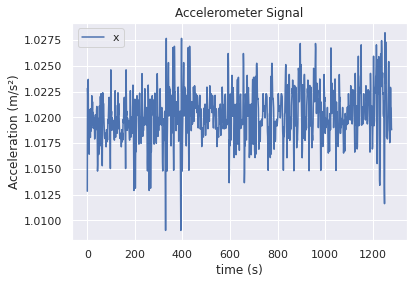

In [4]:
#@Signal Preview
%matplotlib inline
plt.figure()
plt_size = 10
plt.plot(np.concatenate(x_train_sig[0:plt_size],axis=0))
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
plt.legend('x axis')
plt.show()

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vector containing information about the signal properties of each window. These properties can be classified according to their domain as Time, Frequency and Statistical features and allow to characterise the signal compactly, enhancing its characteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/13u7L_5IX3XxFuq_SnbOZF1dXQfcBB0wR3PXhvevhPYA/edit?usp=sharing). Save a copy on your local drive and share it with featext@featext.iam.gserviceaccount.com.

**Change your google sheet file name and the googleSheet_name variable to your name so both have the same name.**

In [5]:
#@title Feature Extraction
googleSheet_name = "Features_dev"
# Extract excel info
cfg_file = tsfel.extract_sheet(googleSheet_name)

# Get features
X_train = tsfel.time_series_features_extractor(cfg_file, x_train_sig, fs=fs)
X_test = tsfel.time_series_features_extractor(cfg_file, x_test_sig, fs=fs)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [8]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [9]:
classifier = RandomForestClassifier()
# Train the classifier
classifier.fit(nX_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) * 100
print(classification_report(y_test, y_test_predict, target_names=activity_labels))
print("Accuracy: " + str(accuracy) + '%')

                    precision    recall  f1-score   support

           WALKING       0.85      0.97      0.90       496
  WALKING_UPSTAIRS       0.84      0.85      0.85       471
WALKING_DOWNSTAIRS       0.92      0.76      0.84       420
           SITTING       0.75      0.48      0.58       491
          STANDING       0.64      0.86      0.73       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.82      2947
         macro avg       0.84      0.82      0.82      2947
      weighted avg       0.83      0.82      0.82      2947

Accuracy: 82.38887003732609%


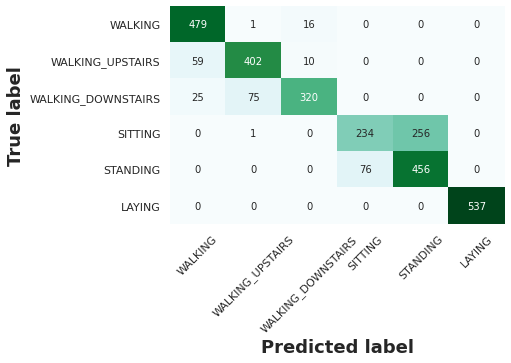

In [10]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
plt.show()

# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.